In [1]:
from openeye import oechem, oemolprop, oegraphsim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem, SimDivFilters, DataStructs
from rdkit.Chem import AllChem, Descriptors
from scipy import stats
from scipy.spatial.distance import euclidean
import seaborn as sns
from library_enum import *

%matplotlib inline

### Pseudocode

1. Load in BB datasets
2. Select cost filter
3. Select MW filter
4. Set random seed
5. Choose selection strategy
6. Enumerate library products

### Load in primary amine and carboxylic acid BB datasets

In [19]:
df = pd.read_csv('../files/truncates_UMAP.csv')

pamine_df = pd.read_csv('../files/pamine_df.csv')
cooh_df = pd.read_csv('../files/cooh_df.csv')

pamine_umap = pamine_df.merge(df, on='truncate_SMILES')
cooh_umap = cooh_df.merge(df, on='truncate_SMILES')

In [20]:
pamine_umap['mol'] = pamine_umap['BB_SMILES'].apply(Chem.MolFromSmiles)
cooh_umap['mol'] = cooh_umap['BB_SMILES'].apply(Chem.MolFromSmiles)

In [21]:
pamine_umap['fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in pamine_umap['mol']]
cooh_umap['fp'] = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=3, nBits=2048) for mol in cooh_umap['mol']]

In [22]:
pamine_umap['MW'] = pamine_umap['mol'].apply(Chem.Descriptors.MolWt)
cooh_umap['MW'] = cooh_umap['mol'].apply(Chem.Descriptors.MolWt)

### Create custom library function

### Select cost and MW filters

In [6]:
cost = 250

MW1 = 200
MW2 = 250
MW3 = 300

In [7]:
l1p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost) & (pamine_umap['MW'] <= MW1)]
l1p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost) & (cooh_umap['MW'] <= MW1)]

l2p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost) & (pamine_umap['MW'] <= MW2)]
l2p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost) & (cooh_umap['MW'] <= MW2)]

l3p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost) & (pamine_umap['MW'] <= MW3)]
l3p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost) & (cooh_umap['MW'] <= MW3)]

### Choose selection strategy

In [8]:
# Library 1
l1p1_BBs = random_selection(l1p1_sele, 192, seed=0)
l1p2_BBs = random_selection(l1p2_sele, 192, seed=0)

# Library 2
l2p1_BBs = random_selection(l2p1_sele, 192, seed=0)
l2p2_BBs = random_selection(l2p2_sele, 192, seed=0)

# Library 3
l3p1_BBs = random_selection(l3p1_sele, 192, seed=0)
l3p2_BBs = random_selection(l3p2_sele, 192, seed=0)

In [570]:
#pamine_sele_rand = random_selection(pamine_sele_2, 192, seed=1)
#cooh_sele_rand = random_selection(cooh_sele_2, 192, seed=1)

In [572]:
#pamine_sele_div = diversity_selection(pamine_sele_2, 192, seed=0)
#cooh_sele_div = diversity_selection(cooh_sele_2, 192, seed=0)

### Enumerate library products

In [64]:
def lib_enum(pamine_selection, cooh_selection):
    #libgen = oechem.OELibraryGen('[#6X4,#6X3$(*~[!#8,!X1]):1]-[#7X3:2]([#1:3])[#1:4].[#6:10](=[O:11])[O:12][H:13]>>[#6:1][N:2]([H:4])[#6:10](=[O:11])')
    #libgen = oechem.OELibraryGen('[!#8,!X1]~[#6:1]-[#7X3:2]([#1:3])[#1:4].[#6:10](=[#8:11])[#8:12][#1:13]>>[#6:1][#7:2]([#1:3])[#6:10](=[#8:11])')
    libgen = oechem.OELibraryGen('[#6:1][N:2]([H:3])[H:4].[#6:10](=[O:11])[O:12][H:13]>>[#6:1][N:2]([H:3])[#6:10](=[O:11])')

    products = []
    tracker = {}
    for i in range(len(pamine_selection)):
        for j in range(len(cooh_selection)):
            pamine_bb = pamine_selection['BB_SMILES'].iloc[i]
            cooh_bb = cooh_selection['BB_SMILES'].iloc[j]

            mol = oechem.OEGraphMol()
            oechem.OEParseSmiles(mol, pamine_bb)
            libgen.SetStartingMaterial(mol, 0)

            mol.Clear()
            oechem.OEParseSmiles(mol, cooh_bb)
            libgen.SetStartingMaterial(mol, 1)

            k = 0
            for index, product in enumerate(libgen.GetProducts()):
                smi = oechem.OECreateCanSmiString(product)
                products.append(smi)
                k += 1

            tracker[f'({i},{j})'] = k
    return products, tracker

In [65]:
lib1, track1 = lib_enum(l1p1_BBs, l1p2_BBs)
#lib2, track2 = lib_enum(l2p1_BBs, l2p2_BBs)
#lib3, track3 = lib_enum(l3p1_BBs, l3p2_BBs)

In [66]:
combos = np.array(list(track1.keys()))
nprod = np.array(list(track1.values()))

In [86]:
ind = np.where(nprod > 1)[0]

In [89]:
def has_group(SMILES, group):
    '''
    Returns True if the SMILES string contains the protecting group of interest
    '''
    ss = oechem.OESubSearch(group)
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, SMILES)
    oechem.OEPrepareSearch(mol, ss)
    return ss.SingleMatch(mol)

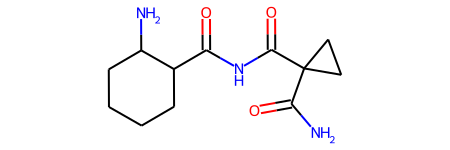

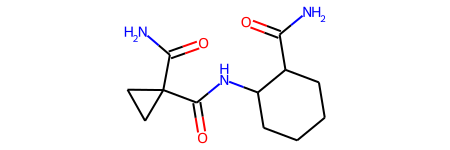

In [88]:
smi_ind = np.cumsum(nprod)[ind[0]]
display(Chem.MolFromSmiles(lib1[smi_ind]))
display(Chem.MolFromSmiles(lib1[smi_ind+1]))

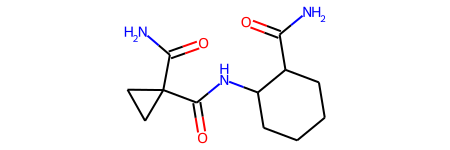

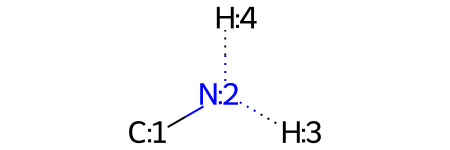

False


In [105]:
m = Chem.MolFromSmiles(lib1[smi_ind+1])
patt = Chem.MolFromSmarts('[#6:1]-[#7X3:2]([#1:3])[#1:4]')
display(m)
display(patt)
print(m.HasSubstructMatch(patt))

In [96]:
print(lib1[smi_ind])
print(lib1[smi_ind+1])

C1CCC(C(C1)C(=O)NC(=O)C2(CC2)C(=O)N)N
C1CCC(C(C1)C(=O)N)NC(=O)C2(CC2)C(=O)N


In [93]:
has_group(lib1[smi_ind], '[#6X4:1]-[#7X3:2]([#1:3])[#1:4]')

False

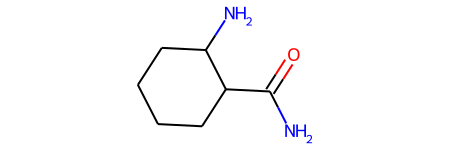

In [82]:
'[#8X1]=[#6X3:1]-[#7X3:2]([#1:3])[#1:4]'

(39,1)


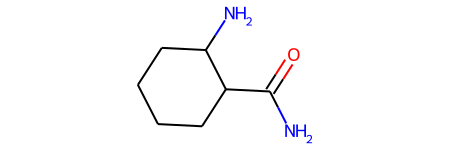

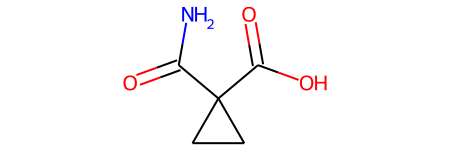

In [56]:
print(combos[7489])
display(Chem.MolFromSmiles(l1p1_BBs.iloc[39]['BB_SMILES']))
display(Chem.MolFromSmiles(l1p2_BBs.iloc[1]['BB_SMILES']))

In [51]:
s = lib1[7490:7492]

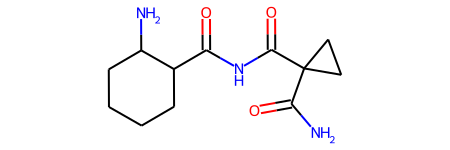

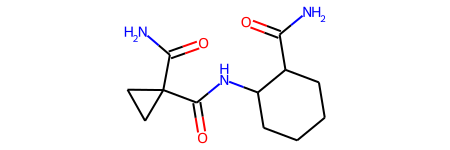

In [52]:
display(Chem.MolFromSmiles(s[0]))
display(Chem.MolFromSmiles(s[1]))

In [15]:
print(len(lib1))
print(len(l1p1_BBs), len(l1p2_BBs))
print(len(l1p1_BBs) * len(l1p2_BBs))

110784
192 192
36864


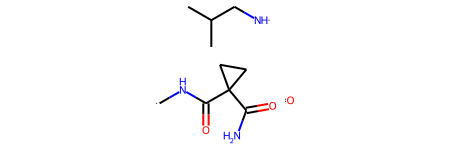

In [31]:
[Chem.MolFromSmiles(x) for x in lib1[3:6]][0]

### Calculate PCP

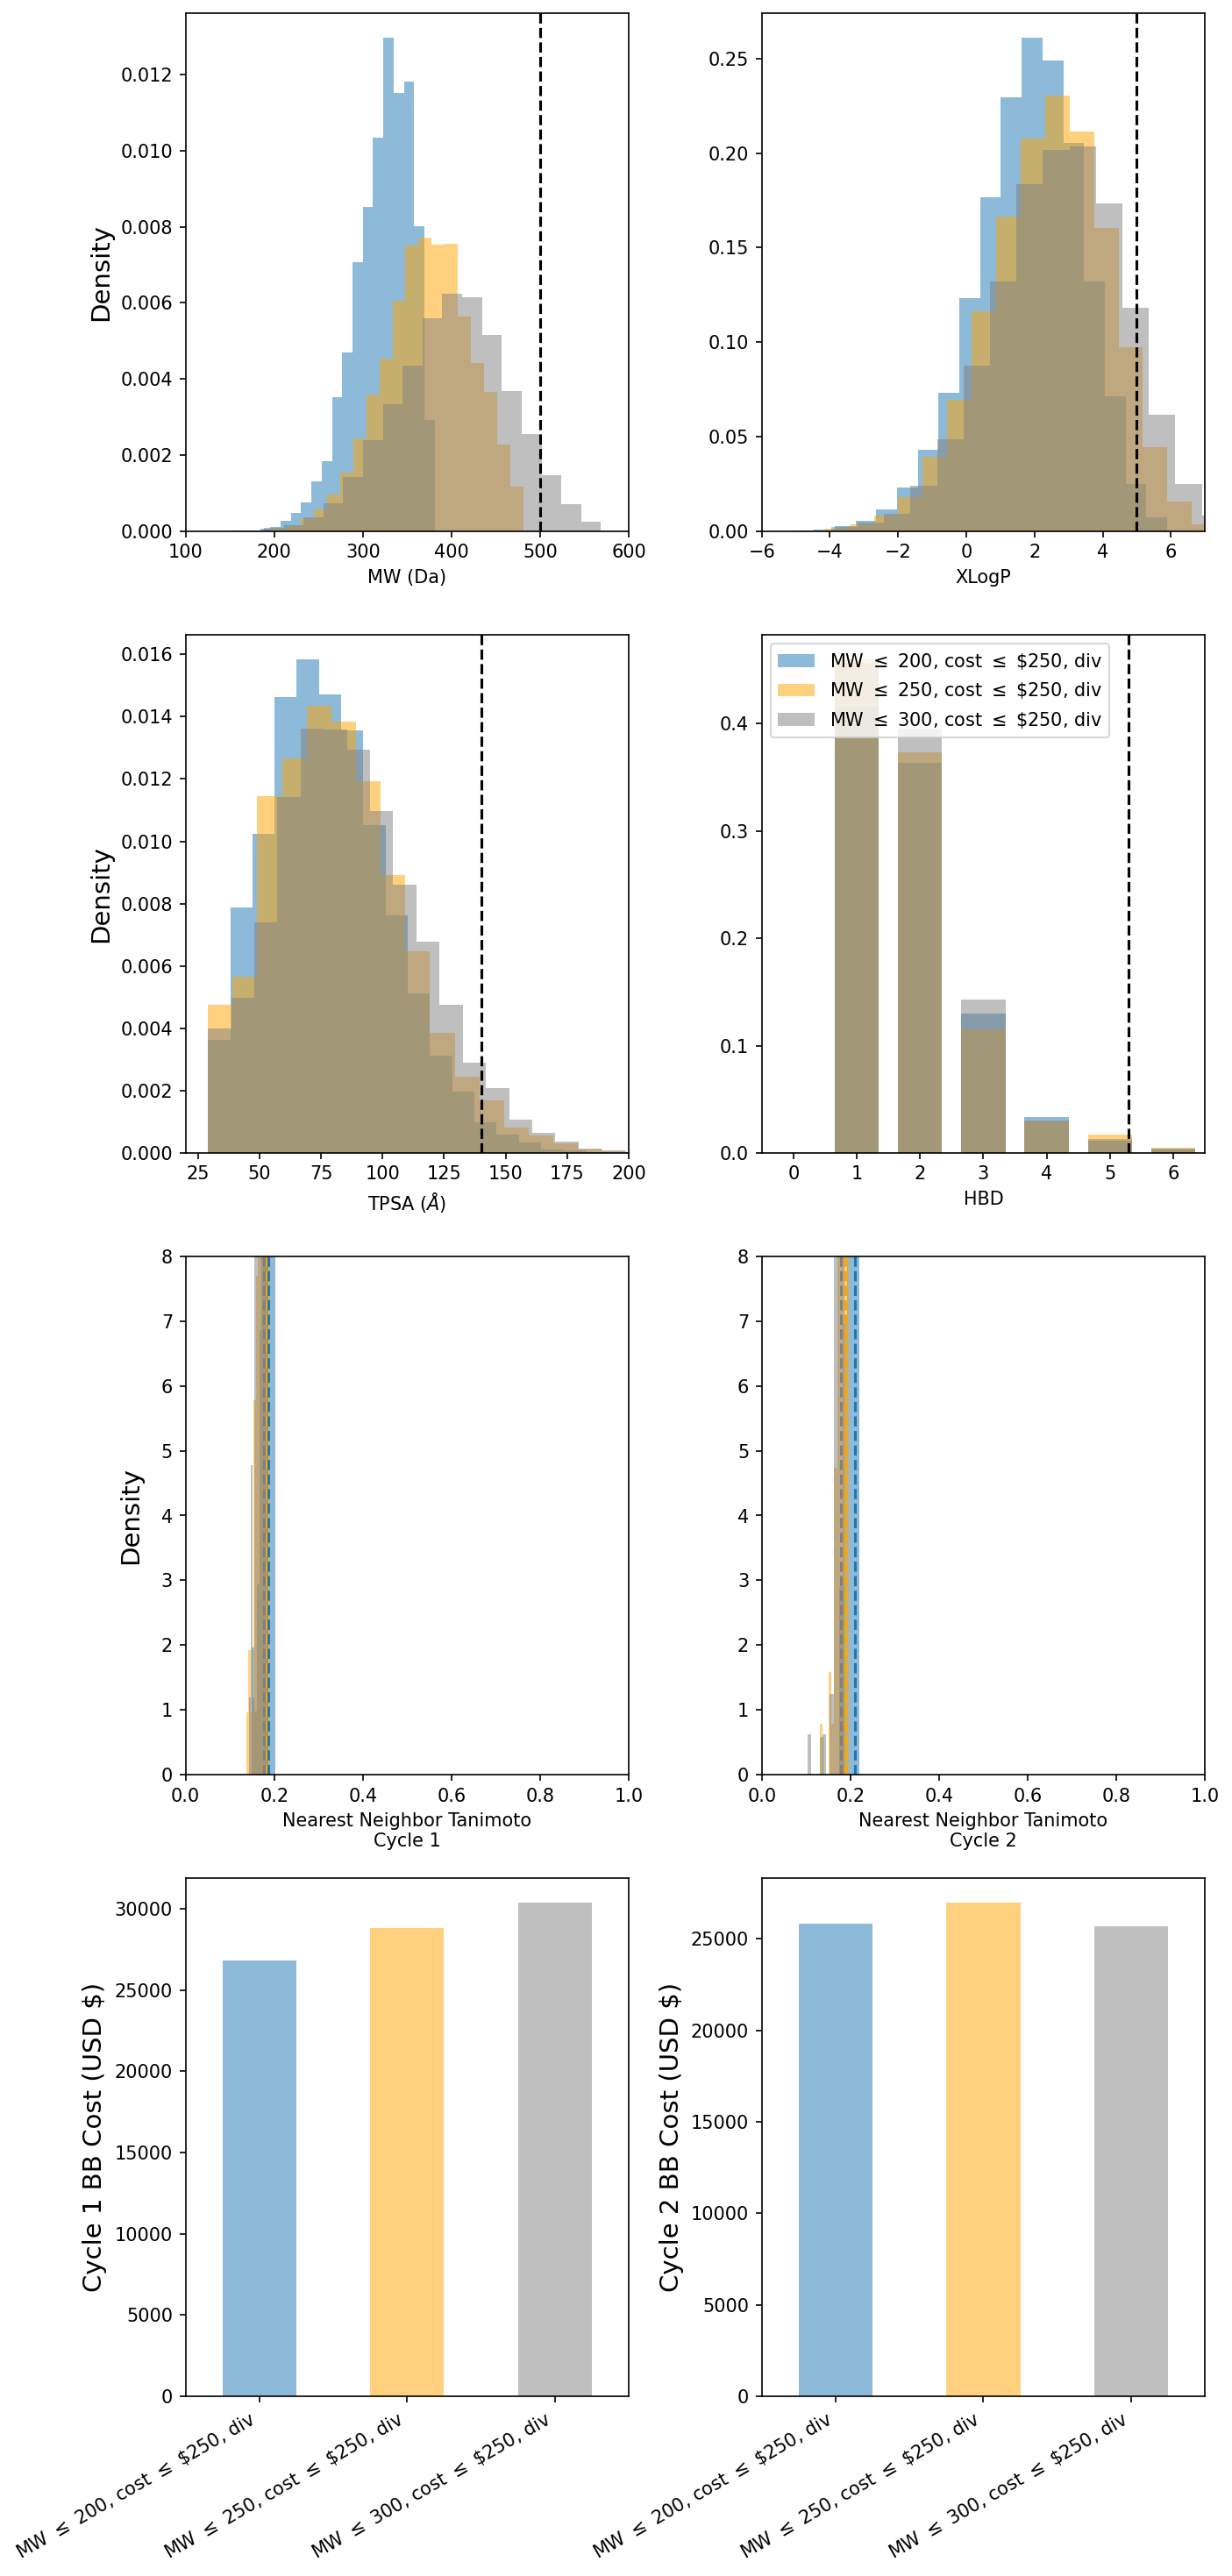

In [859]:
# mw_div_fig = plot_library_stats(l1p1_BBs, l1p2_BBs, lib1, 'MW $\leq$ 200, cost $\leq$ \$250, div',
#                                 l2p1_BBs, l2p2_BBs, lib2, 'MW $\leq$ 250, cost $\leq$ \$250, div',
#                                 l3p1_BBs, l3p2_BBs, lib3, 'MW $\leq$ 300, cost $\leq$ \$250, div')

In [860]:
#mw_div_fig.savefig('../figures/lib_sele_mw_div.png')

In [23]:
def calc_pcp(library):
    library['mol'] = library['SMILES'].apply(Chem.MolFromSmiles)
    library['mw'] = library['mol'].apply(Chem.Descriptors.MolWt)
    library['xlogp'] = library['mol'].apply(Chem.Descriptors.MolLogP)
    library['tpsa'] = library['mol'].apply(Chem.Descriptors.TPSA)
    library['hbd'] = library['mol'].apply(Chem.rdMolDescriptors.CalcNumHBD)
    
    return library

### Preset defaults to: cost $\leq$ 250, MW $\leq$ 250, random selection

#### Constant cost, random selection, different MW


In [106]:
def plot_library_stats(pamine_sele_1, cooh_sele_1, lib1, lib1_label=None,
                 pamine_sele_2=None, cooh_sele_2=None, lib2=None, lib2_label=None,
                 pamine_sele_3=None, cooh_sele_3=None, lib3=None, lib3_label=None):

    library_1 = pd.DataFrame(lib1, columns=["SMILES"])

    # Calculate PCP of enumerated products
    library_1 = calc_pcp(library_1)

    # Calculate cost of BBs
    l1p1_cost = np.sum(pamine_sele_1['Price_250mg'])
    l1p2_cost = np.sum(cooh_sele_1['Price_250mg'])

    # Calculate similarity of BBs
    l1p1_sim = sim_mat(pamine_sele_1, pamine_sele_1)
    l1p2_sim = sim_mat(cooh_sele_1, cooh_sele_1)

    if lib2:
        library_2 = pd.DataFrame(lib2, columns=["SMILES"])
        library_2 = calc_pcp(library_2)

        # Calculate PCP of enumerated products
        library_2 = calc_pcp(library_2)

        # Calculate cost of BBs
        l2p1_cost = np.sum(pamine_sele_2['Price_250mg'])
        l2p2_cost = np.sum(cooh_sele_2['Price_250mg'])

        # Calculate similarity of BBs
        l2p1_sim = sim_mat(pamine_sele_2, pamine_sele_2)
        l2p2_sim = sim_mat(cooh_sele_2, cooh_sele_2)


    if lib3:
        library_3 = pd.DataFrame(lib3, columns=["SMILES"])
        library_3 = calc_pcp(library_3)

        # Calculate PCP of enumerated products
        library_3 = calc_pcp(library_3)

        # Calculate cost of BBs
        l3p1_cost = np.sum(pamine_sele_3['Price_250mg'])
        l3p2_cost = np.sum(cooh_sele_3['Price_250mg'])

        # Calculate similarity of BBs
        l3p1_sim = sim_mat(pamine_sele_3, pamine_sele_3)
        l3p2_sim = sim_mat(cooh_sele_3, cooh_sele_3)


    fig, axs = plt.subplots(4, 2, figsize=(12,24), dpi=150)
    fig.subplots_adjust(wspace=0.3)

    axs[0][0].hist(library_1['mw'], bins=20, alpha=0.5, density=True)
    axs[0][0].axvline(x=500, color='black', linestyle='dashed')

    if lib2:
        axs[0][0].hist(library_2['mw'], bins=20, alpha=0.5, density=True, color='orange')

    if lib3:
        axs[0][0].hist(library_3['mw'], bins=20, alpha=0.5, density=True, color='gray')

    axs[0][0].set_xlabel('MW (Da)', fontsize=14)
    axs[0][0].set_xlim([100, 600])

    axs[0][1].hist(library_1['xlogp'], bins=20, alpha=0.5, density=True)
    axs[0][1].axvline(x=5, color='black', linestyle='dashed')

    if lib2:
        axs[0][1].hist(library_2['xlogp'], bins=20, alpha=0.5, density=True, color='orange')

    if lib3:
        axs[0][1].hist(library_3['xlogp'], bins=20, alpha=0.5, density=True, color='gray')

    axs[0][1].set_xlabel('XLogP', fontsize=14)
    axs[0][1].set_xlim([-6, 7])

    axs[1][0].hist(library_1['tpsa'], bins=20, alpha=0.5, density=True)
    axs[1][0].axvline(x=140, color='black', linestyle='dashed')

    if lib2:
        axs[1][0].hist(library_2['tpsa'], bins=20, alpha=0.5, density=True, color='orange')

    if lib3:
        axs[1][0].hist(library_3['tpsa'], bins=20, alpha=0.5, density=True, color='gray')

    axs[1][0].set_xlabel('TPSA ($\AA$)', fontsize=14)
    axs[1][0].set_xlim([20, 200])

    axs[1][1].hist(library_1['hbd'], bins=np.arange(0.5, np.max(library_1['hbd'])+1.5), rwidth=0.7,
                   alpha=0.5, density=True, label=lib1_label)
    axs[1][1].axvline(x=5.3, color='black', linestyle='dashed')

    if lib2:
        axs[1][1].hist(library_2['hbd'], bins=np.arange(0.5, np.max(library_1['hbd'])+1.5), rwidth=0.7,
                   alpha=0.5, density=True, color='orange', label=lib2_label)

    if lib3:
        axs[1][1].hist(library_3['hbd'], bins=np.arange(0.5, np.max(library_1['hbd'])+1.5), rwidth=0.7,
                   alpha=0.5, density=True, color='gray', label=lib3_label)

    axs[1][1].set_xlabel('HBD', fontsize=14)
    axs[1][1].set_xlim([-0.5, 6.5])
    axs[1][1].legend(loc='best')

    axs[2][0].hist(np.max(l1p1_sim, axis=1), alpha=0.5, density=True)
    axs[2][0].axvline(x=np.median(np.max(l1p1_sim, axis=1)), linestyle='dashed')

    if lib2:
        axs[2][0].hist(np.max(l2p1_sim, axis=1), alpha=0.5, density=True, color='orange')
        axs[2][0].axvline(x=np.median(np.max(l2p1_sim, axis=1)), linestyle='dashed', color='orange')

    if lib3:
        axs[2][0].hist(np.max(l3p1_sim, axis=1), alpha=0.5, density=True, color='gray')
        axs[2][0].axvline(x=np.median(np.max(l3p1_sim, axis=1)), linestyle='dashed', color='gray')

    axs[2][0].set_xlabel('Nearest Neighbor Tanimoto\nCycle 1', fontsize=14)
    axs[2][0].set_xlim([0, 1.0])
    axs[2][0].set_ylim([0, 8])

    axs[2][1].hist(np.max(l1p2_sim, axis=1), alpha=0.5, density=True)
    axs[2][1].axvline(x=np.median(np.max(l1p2_sim, axis=1)), linestyle='dashed')

    if lib2:
        axs[2][1].hist(np.max(l2p2_sim, axis=1), alpha=0.5, density=True, color='orange')
        axs[2][1].axvline(x=np.median(np.max(l2p2_sim, axis=1)), linestyle='dashed', color='orange')


    if lib3:
        axs[2][1].hist(np.max(l3p2_sim, axis=1), alpha=0.5, density=True, color='gray')
        axs[2][1].axvline(x=np.median(np.max(l3p2_sim, axis=1)), linestyle='dashed', color='gray')

    axs[2][1].set_xlabel('Nearest Neighbor Tanimoto\nCycle 2', fontsize=14)
    axs[2][1].set_xlim([0, 1.0])
    axs[2][1].set_ylim([0, 8])

    axs[0][0].set_ylabel('Density', fontsize=14)
    axs[1][0].set_ylabel('Density', fontsize=14)
    axs[2][0].set_ylabel('Density', labelpad=10, fontsize=14)


    if lib3:
        axs[3][0].bar(x=-0.5, height=l1p1_cost, width=0.5, alpha=0.5)
        axs[3][0].bar(x=0.5, height=l2p1_cost, width=0.5, alpha=0.5, color='orange')
        axs[3][0].bar(x=1.5, height=l3p1_cost, width=0.5, alpha=0.5, color='gray')
        axs[3][0].set_xticks([-0.5, 0.5, 1.5])
        axs[3][0].set_xticklabels([lib1_label, lib2_label, lib3_label], rotation=30, ha='right')
        axs[3][0].set_xlim([-1, 2])
        axs[3][0].set_ylabel('Cycle 1 BB Cost (USD $)', fontsize=14)

        axs[3][1].bar(x=-0.5, height=l1p2_cost, width=0.5, alpha=0.5)
        axs[3][1].bar(x=0.5, height=l2p2_cost, width=0.5, alpha=0.5, color='orange')
        axs[3][1].bar(x=1.5, height=l3p2_cost, width=0.5, alpha=0.5, color='gray')
        axs[3][1].set_xticks([-0.5, 0.5, 1.5])
        axs[3][1].set_xticklabels([lib1_label, lib2_label, lib3_label], rotation=30, ha='right')
        axs[3][1].set_xlim([-1, 2])
        axs[3][1].set_ylabel('Cycle 2 BB Cost (USD $)', fontsize=14)


    elif lib2:
        axs[3][0].bar(x=-0.25, height=l1p1_cost, width=0.66, alpha=0.5)
        axs[3][0].bar(x=1.25, height=l2p1_cost, width=0.66, alpha=0.5, color='orange')
        axs[3][0].set_xticks([-0.25, 1.25])
        axs[3][0].set_xticklabels([lib1_label, lib2_label], rotation=30, ha='right')
        axs[3][0].set_xlim([-1, 2])
        axs[3][0].set_ylabel('Cycle 1 BB Cost (USD $)', fontsize=14)


        axs[3][1].bar(x=-0.25, height=l1p2_cost, width=0.66, alpha=0.5)
        axs[3][1].bar(x=1.25, height=l2p2_cost, width=0.66, alpha=0.5, color='orange')
        axs[3][1].set_xticks([-0.25, 1.25])
        axs[3][1].set_xticklabels([lib1_label, lib2_label], rotation=30, ha='right')
        axs[3][1].set_xlim([-1, 2])
        axs[3][1].set_ylabel('Cycle 2 BB Cost (USD $)', fontsize=14)

    else:
        axs[3][0].bar(x=0.5, height=l1p1_cost, width=1, alpha=0.5)
        axs[3][0].set_xticks([0.5])
        axs[3][0].set_xticklabels([lib1_label], rotation=30, ha='right')
        axs[3][0].set_xlim([-1, 2])
        axs[3][0].set_ylabel('Cycle 1 BB Cost (USD $)', fontsize=14)

        axs[3][1].bar(x=0.5, height=l1p2_cost, width=1, alpha=0.5)
        axs[3][1].set_xticks([0.5])
        axs[3][1].set_xticklabels([lib1_label], rotation=30, ha='right')
        axs[3][1].set_xlim([-1, 2])
        axs[3][1].set_ylabel('Cycle 2 BB Cost (USD $)', fontsize=14)

    return fig

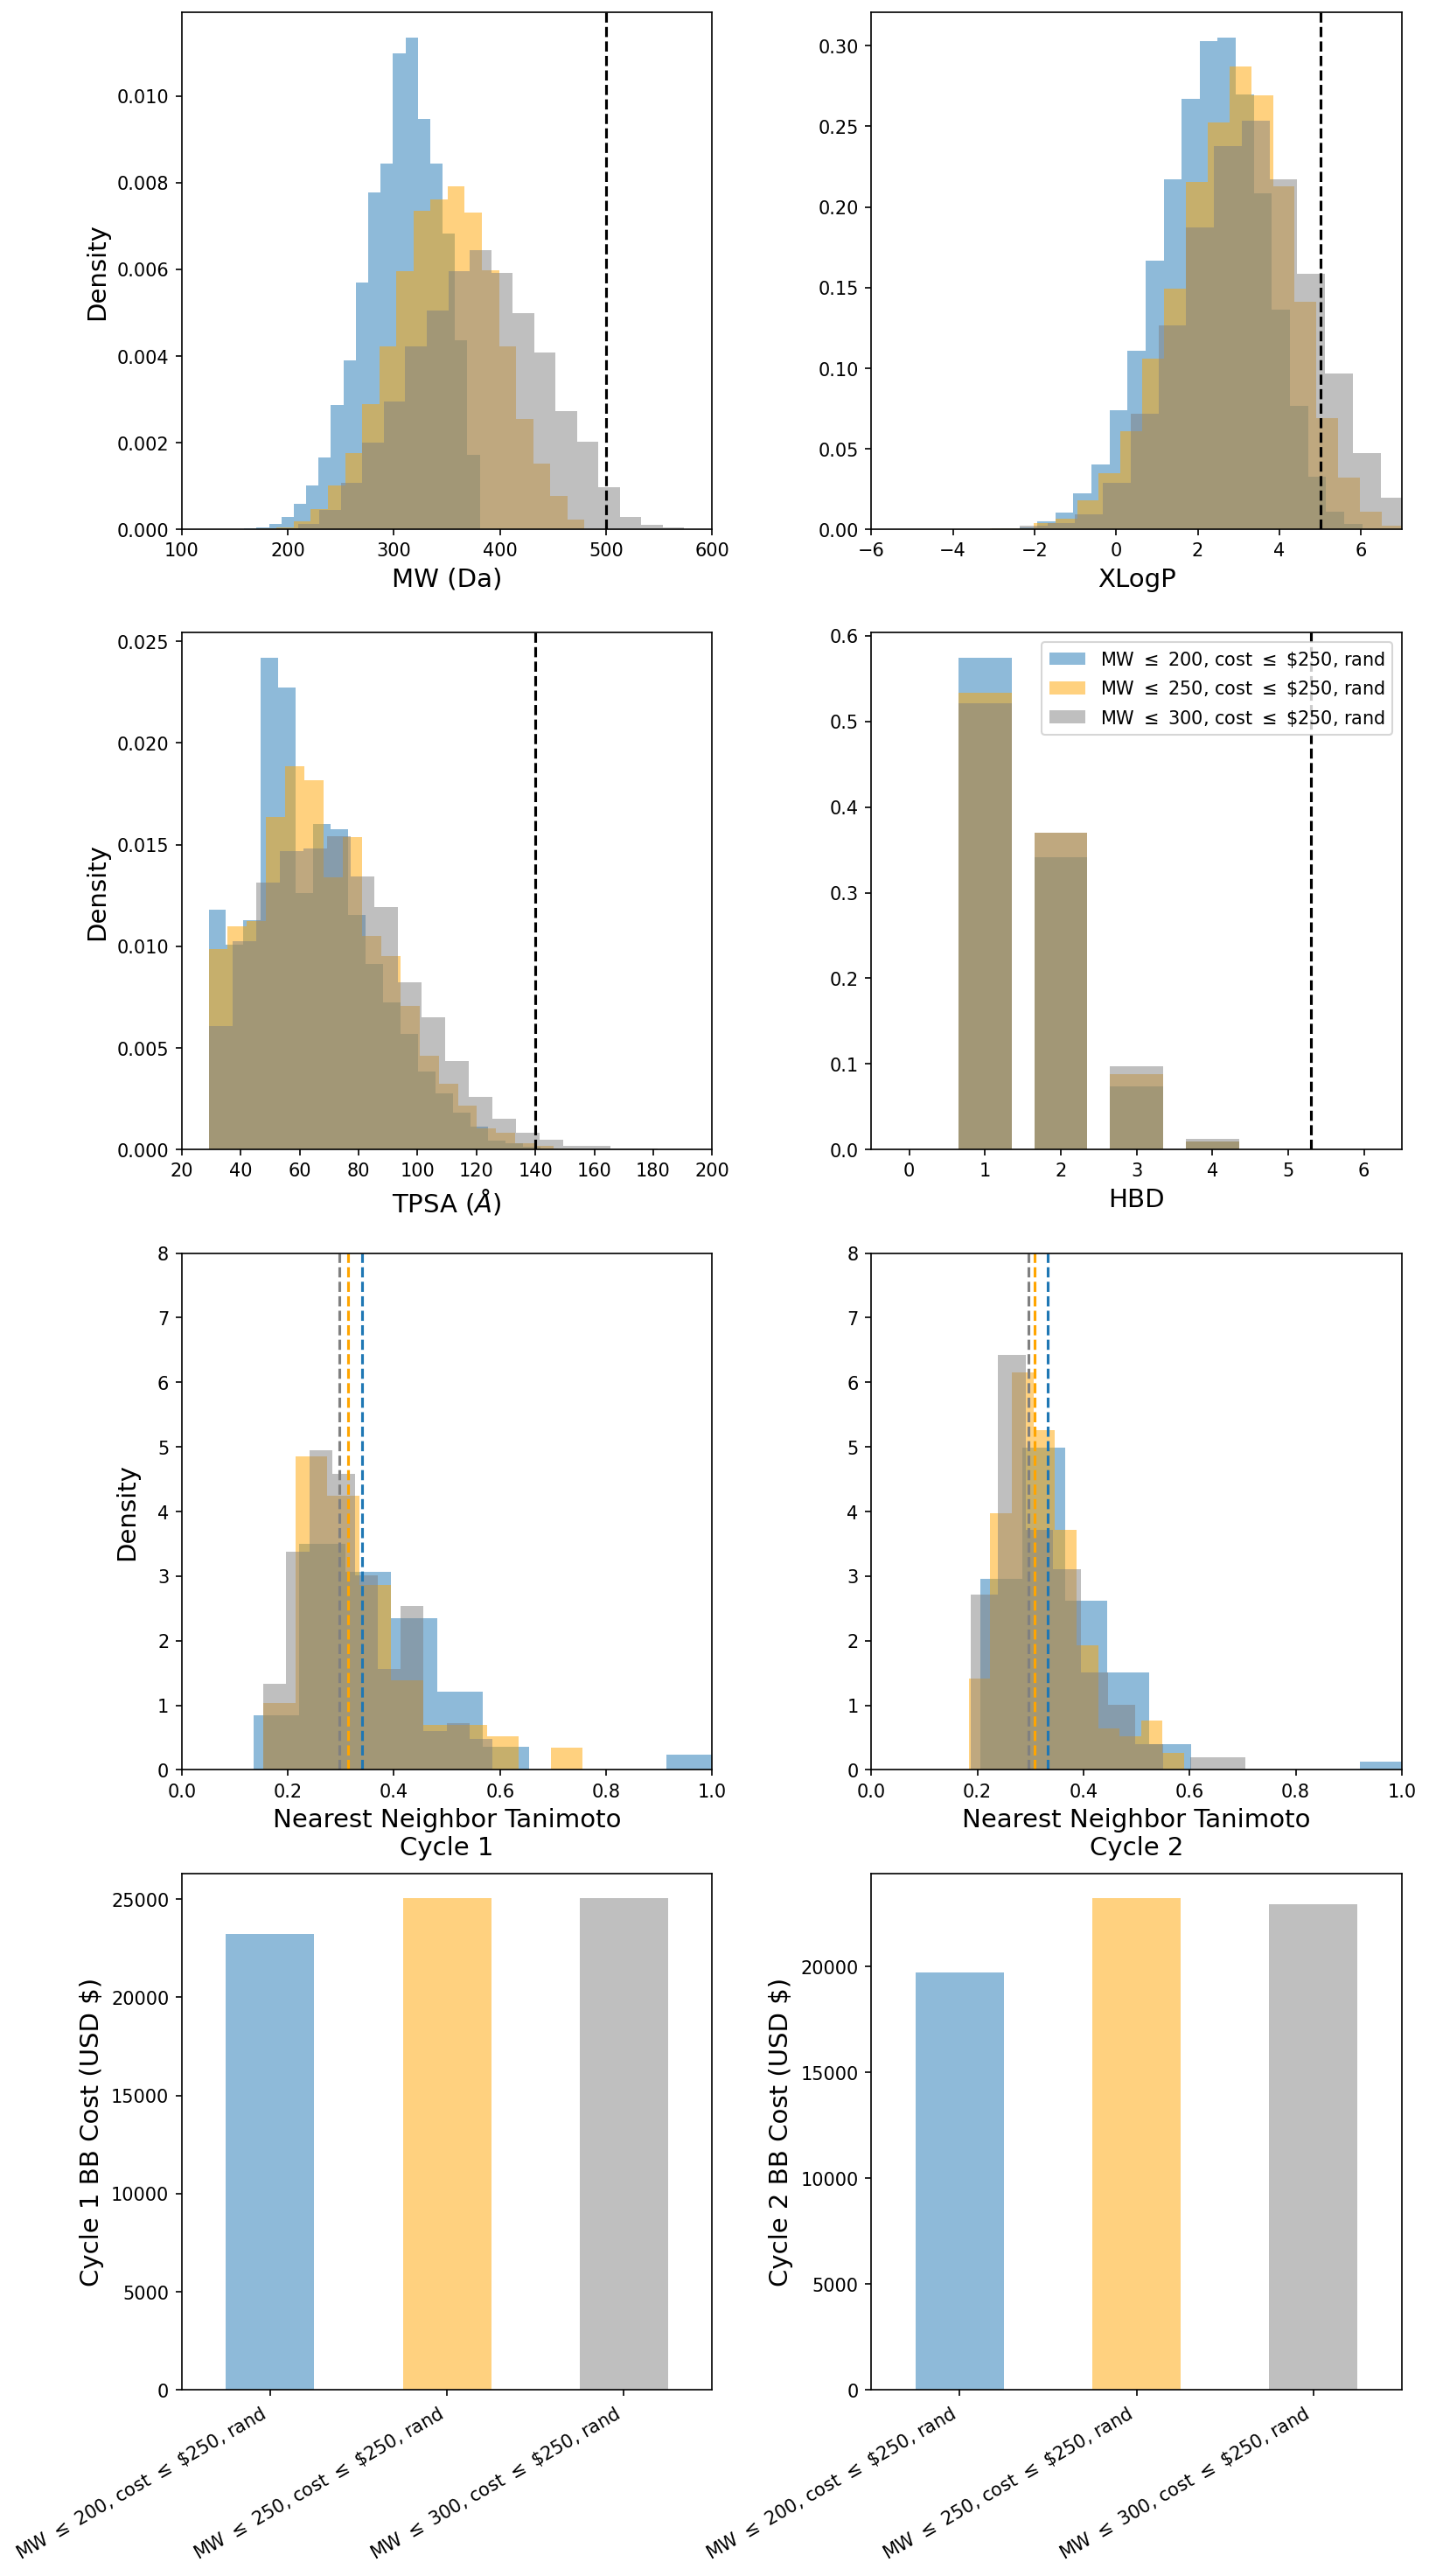

In [107]:
cost1 = 250
cost2 = 250
cost3 = 250

MW1 = 200
MW2 = 250
MW3 = 300

l1p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost1) & (pamine_umap['MW'] <= MW1)]
l1p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost1) & (cooh_umap['MW'] <= MW1)]

l2p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost2) & (pamine_umap['MW'] <= MW2)]
l2p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost2) & (cooh_umap['MW'] <= MW2)]

l3p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost3) & (pamine_umap['MW'] <= MW3)]
l3p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost3) & (cooh_umap['MW'] <= MW3)]

# Library 1
l1p1_BBs = random_selection(l1p1_sele, 192, seed=0)
l1p2_BBs = random_selection(l1p2_sele, 192, seed=0)

# Library 2
l2p1_BBs = random_selection(l2p1_sele, 192, seed=0)
l2p2_BBs = random_selection(l2p2_sele, 192, seed=0)

# Library 3
l3p1_BBs = random_selection(l3p1_sele, 192, seed=0)
l3p2_BBs = random_selection(l3p2_sele, 192, seed=0)

# Enumerate Products
lib1, track1 = lib_enum(l1p1_BBs, l1p2_BBs)
lib2, track2 = lib_enum(l2p1_BBs, l2p2_BBs)
lib3, track3 = lib_enum(l3p1_BBs, l3p2_BBs)

# Generate library summary
mw_fig = plot_library_stats(l1p1_BBs, l1p2_BBs, lib1, 'MW $\leq$ 200, cost $\leq$ \$250, rand',
                            l2p1_BBs, l2p2_BBs, lib2, 'MW $\leq$ 250, cost $\leq$ \$250, rand',
                            l3p1_BBs, l3p2_BBs, lib3, 'MW $\leq$ 300, cost $\leq$ \$250, rand')

# Save figure
#mw_fig.savefig('../figures/lib_enum_MW.png', bbox_inches='tight')

#### Constant MW, random selection, different cost

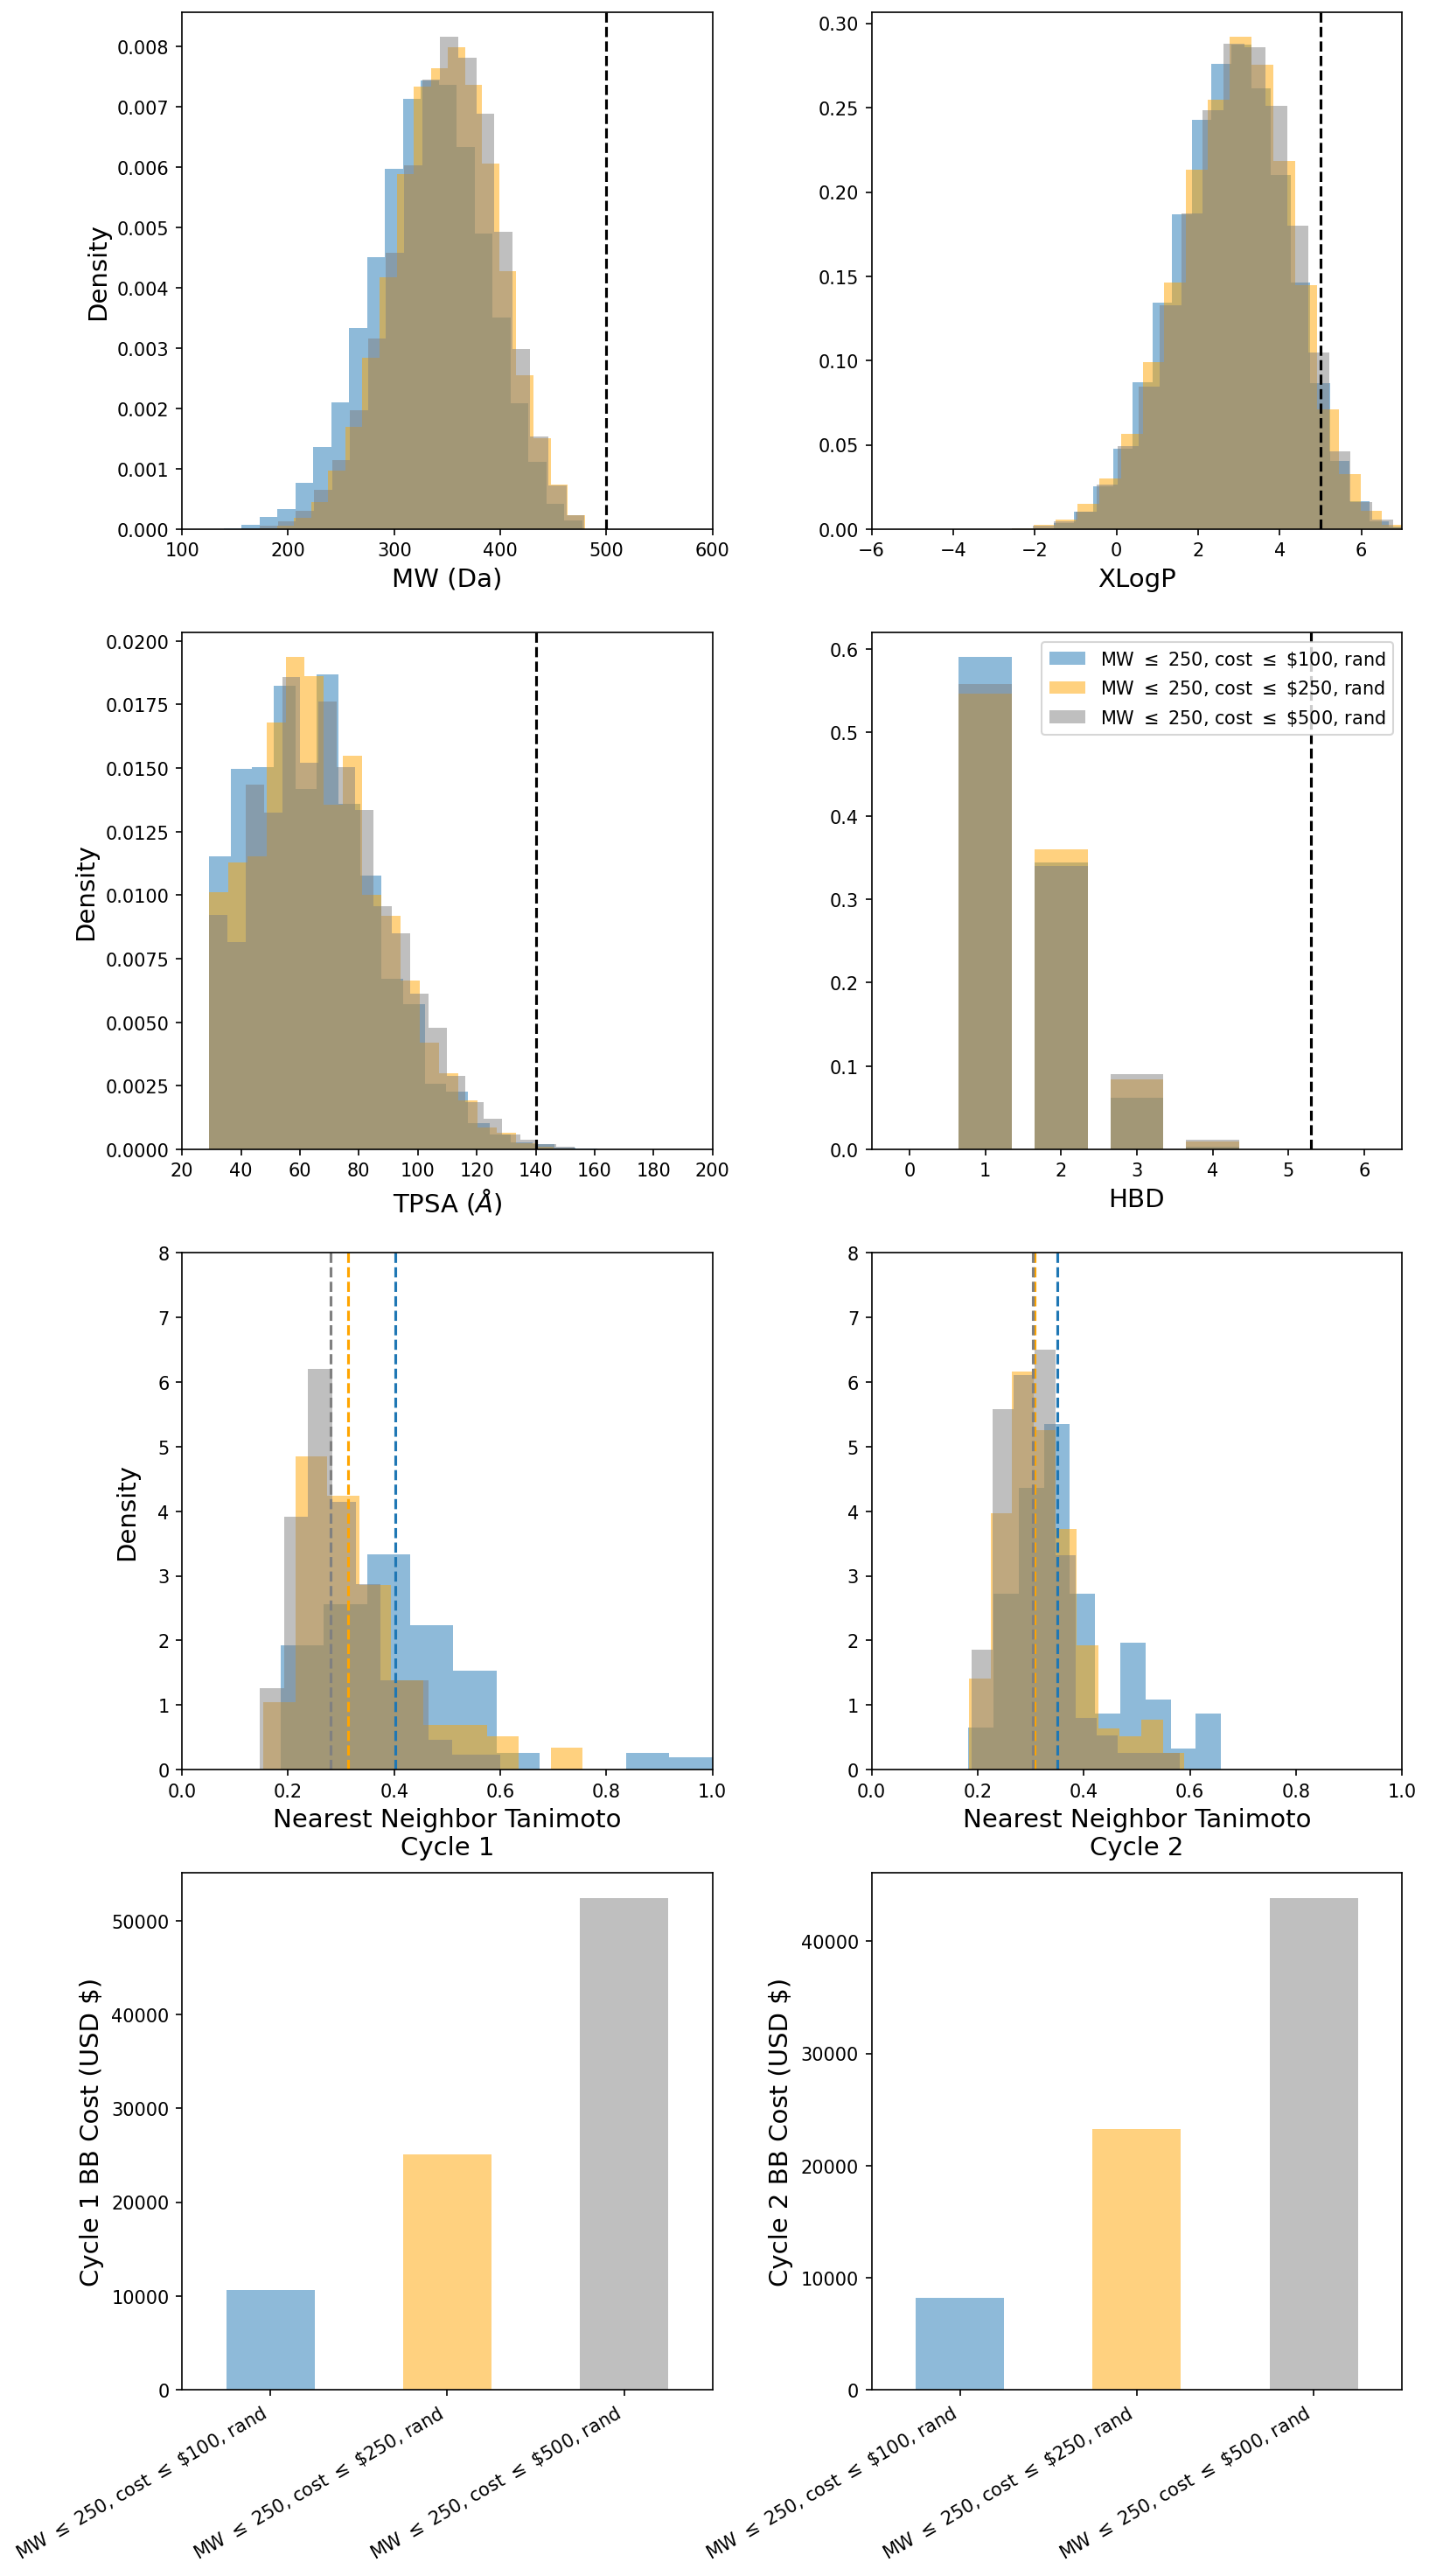

In [889]:
cost1 = 100
cost2 = 250
cost3 = 500

MW1 = 250
MW2 = 250
MW3 = 250

l1p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost1) & (pamine_umap['MW'] <= MW1)]
l1p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost1) & (cooh_umap['MW'] <= MW1)]

l2p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost2) & (pamine_umap['MW'] <= MW2)]
l2p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost2) & (cooh_umap['MW'] <= MW2)]

l3p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost3) & (pamine_umap['MW'] <= MW3)]
l3p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost3) & (cooh_umap['MW'] <= MW3)]

# Library 1
l1p1_BBs = random_selection(l1p1_sele, 192, seed=0)
l1p2_BBs = random_selection(l1p2_sele, 192, seed=0)

# Library 2
l2p1_BBs = random_selection(l2p1_sele, 192, seed=0)
l2p2_BBs = random_selection(l2p2_sele, 192, seed=0)

# Library 3
l3p1_BBs = random_selection(l3p1_sele, 192, seed=0)
l3p2_BBs = random_selection(l3p2_sele, 192, seed=0)

# Enumerate Products
lib1, track1 = lib_enum(l1p1_BBs, l1p2_BBs)
lib2, track2 = lib_enum(l2p1_BBs, l2p2_BBs)
lib3, track3 = lib_enum(l3p1_BBs, l3p2_BBs)

# Generate library summary
cost_fig = plot_library_stats(l1p1_BBs, l1p2_BBs, lib1, 'MW $\leq$ 250, cost $\leq$ \$100, rand',
                              l2p1_BBs, l2p2_BBs, lib2, 'MW $\leq$ 250, cost $\leq$ \$250, rand',
                              l3p1_BBs, l3p2_BBs, lib3, 'MW $\leq$ 250, cost $\leq$ \$500, rand')

# Save figure
cost_fig.savefig('../figures/lib_enum_cost.png', bbox_inches='tight')

#### Constant cost, constant MW, different selection rules

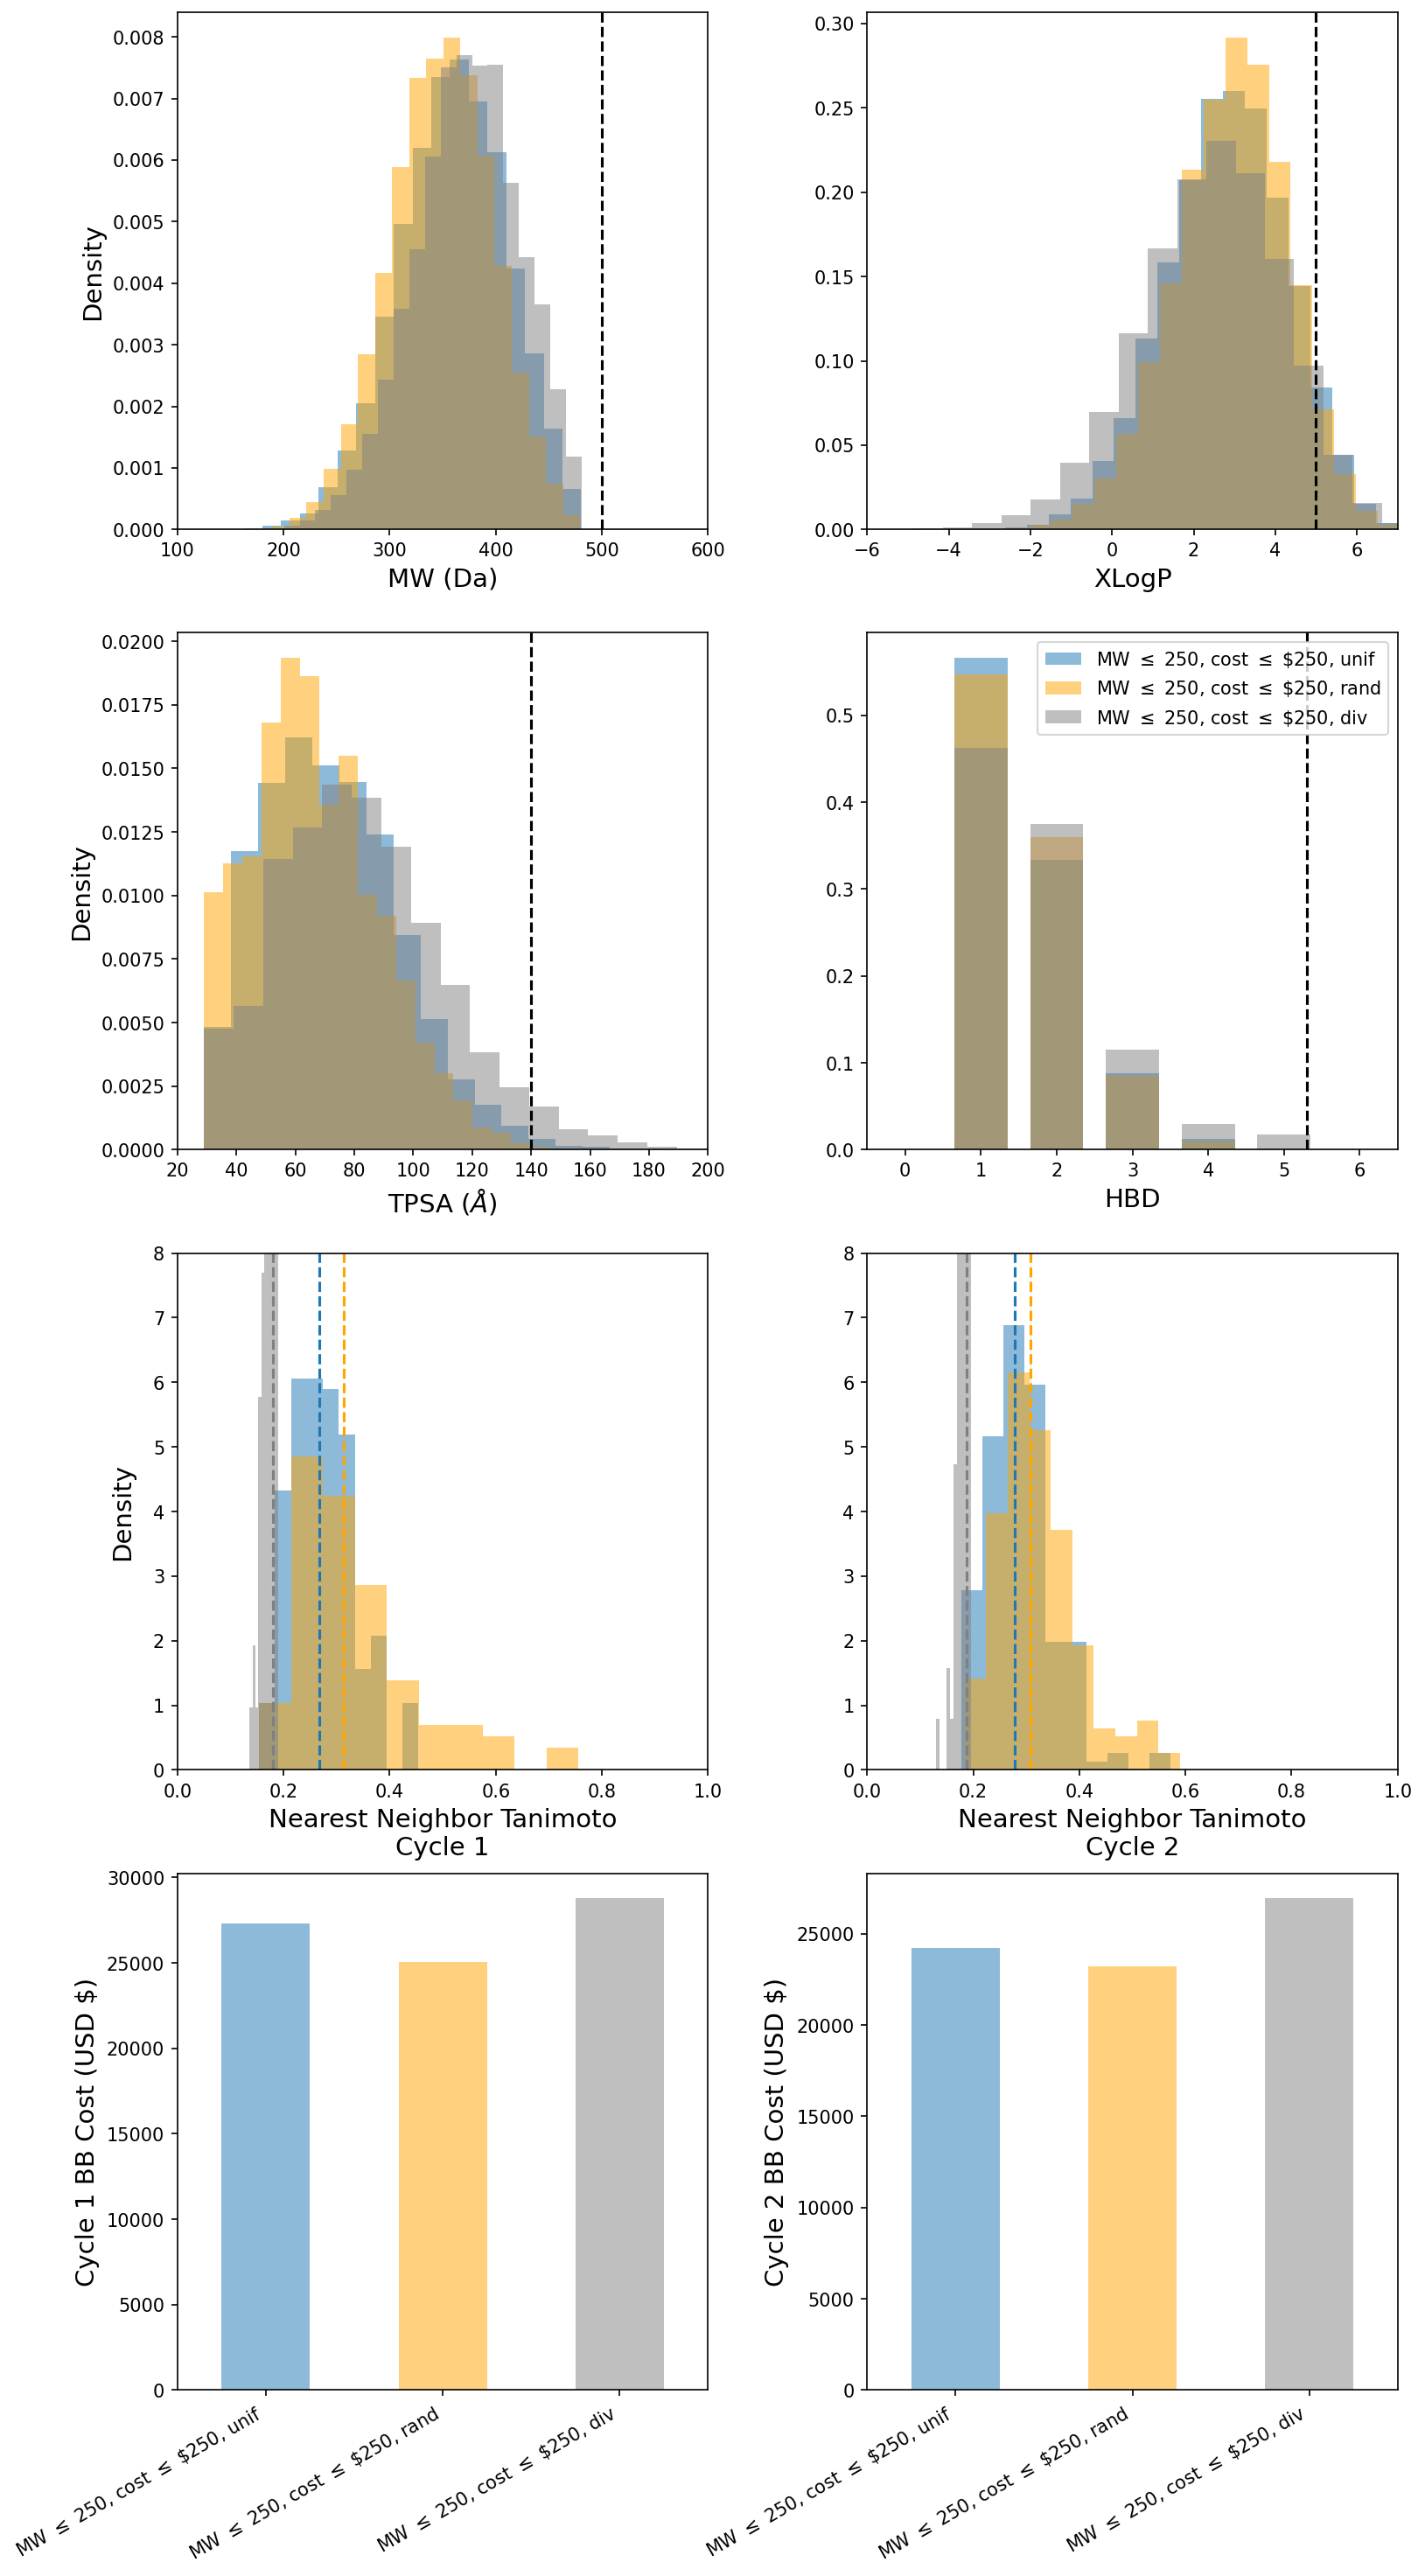

In [890]:
cost1 = 250
cost2 = 250
cost3 = 250

MW1 = 250
MW2 = 250
MW3 = 250

l1p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost1) & (pamine_umap['MW'] <= MW1)]
l1p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost1) & (cooh_umap['MW'] <= MW1)]

l2p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost2) & (pamine_umap['MW'] <= MW2)]
l2p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost2) & (cooh_umap['MW'] <= MW2)]

l3p1_sele = pamine_umap.loc[(pamine_umap['Price_250mg'] <= cost3) & (pamine_umap['MW'] <= MW3)]
l3p2_sele = cooh_umap.loc[(cooh_umap['Price_250mg'] <= cost3) & (cooh_umap['MW'] <= MW3)]

# Library 1
l1p1_BBs = uniform_selection(l1p1_sele, 192, seed=0)
l1p2_BBs = uniform_selection(l1p2_sele, 192, seed=0)

# Library 2
l2p1_BBs = random_selection(l2p1_sele, 192, seed=0)
l2p2_BBs = random_selection(l2p2_sele, 192, seed=0)

# Library 3
l3p1_BBs = diversity_selection(l3p1_sele, 192, seed=0)
l3p2_BBs = diversity_selection(l3p2_sele, 192, seed=0)

# Enumerate Products
lib1, track1 = lib_enum(l1p1_BBs, l1p2_BBs)
lib2, track2 = lib_enum(l2p1_BBs, l2p2_BBs)
lib3, track3 = lib_enum(l3p1_BBs, l3p2_BBs)

# Generate library summary
selection_fig = plot_library_stats(l1p1_BBs, l1p2_BBs, lib1, 'MW $\leq$ 250, cost $\leq$ \$250, unif',
                                   l2p1_BBs, l2p2_BBs, lib2, 'MW $\leq$ 250, cost $\leq$ \$250, rand',
                                   l3p1_BBs, l3p2_BBs, lib3, 'MW $\leq$ 250, cost $\leq$ \$250, div')

# Save figure
selection_fig.savefig('../figures/lib_enum_selection.png', bbox_inches='tight')